**Nome:** Riccardo <br>
**Cognome:** Confalonieri<br>
**Numero matricola:** 830404<br>
**E-mail:** r.confalonieri5@campus.unimib.it<br>
**A.A.** 2021-2022<br>

# **Digital Signal and Image Management - Assignment 1**<br/>
**Master's Degree in Data Science (A.Y. 2021/2022)**<br/>
**University of Milano - Bicocca**<br/>

Simone Bianco, Marco Buzzelli

## Descrizione
<p align = 'justify'>
Classificare dei segnali monodimensionali, audio, attraverso l'impementazione di una SVM. Il dataset a disposizione è composto da 1500 file wav nei quali tre differenti soggetti pronunciano i numeri da 0 a 9. Ogni file contiene la pronuncia di un singolo numero, ed ogni soggetto pronuncia ogni numero cinquanta volte. <br/>
L'obiettivo è predirre il numero pronunciato a partire dal file audio e dalle sue caratteristiche. <i>Implementare quindi la funzione Zero-Crossing Rate (ZCR) che estrae dal file audio la feature riportante il numero di cambi di segno presenti nel segnale. Valutare quindi le performance ottenute con l'utilizzo di questa nuova feature anche in combinazione con le altre già disponibili.<i/>
<p/>

### Import delle librerie

In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Advanced audio features
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

# beautiful confusion matrix
import seaborn as sn

### Data import

In [2]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Mounted at /content/gdrive


### Data loader

1. Load the data from disk
2. Extract the class specified in the filename
3. Split audio tracks into training set and test set
4. Normalize the data using training set statistics

In [3]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test


### Features creation

In [4]:
def crop(input, size=100):
    # Remove any values exceeding the given limit
    output = input[0:min(size, input.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

In [5]:
def sdev(input):
  # ritorna la deviazione standard del segnale
  
  # utilizzo keepdims=True perchè in questo modo mi viene restituito un vettore
  # di dimensione 1 invece di uno scalare. Questo è necessario per via della libreria
  # scikit-learn che non può utilizzare uno scalare.
    return np.std(input, keepdims=True)

In [6]:
def avg(input):
  # ritorna la media del segnale
    return np.mean(input, keepdims=True)

def aavg(input):
  # ritorna la media assoluta del segnale
    return np.mean(np.abs(input), keepdims=True)

The average value of an audio signal is typically close to zero, since the signal oscillates around such value.

A more interesting feature could be the average of the *absolute* values (`avg()`).

**Note:** by definition, this feature is highly correlated to the "volume" of the audio track.

In [7]:
def duration(input):
  # ritorna la durata del segnale
    return input.shape

In [8]:
def energy(input):
  # Ritorna l'energia del segnale
    return np.sum((input*1.0)**2, keepdims=True)

#### Zero-Crossing Rate:
count how many times the signal goes from positive to negative, and from negative to positive.


In [9]:
def zcr(input):
  # np.sign: estraggo il segno di ogni elemento dell'input
  # np.diff: calcola la differenza tra un elemento ed il successivo
  # np.count_nonzero: conto quanti valori sono diversi da zero
  # Gli zero sono contati con un segno diverso da tutti gli altri (gestione automatica di np.sign)
  return np.count_nonzero(np.diff(np.sign(input)), keepdims=True)

  # si poteva fare la stessa cosa sfruttando un ciclo for come il seguente
  #return np.sum([np.sign(input[value]) != np.sign(input[value-1]) for value in range(1, len(input))], keepdims=True) 

Per l’implementazione della funzione zcr ho seguito il consiglio di shiftare l’array di una posizione in avanti e confrontare i segni delle coppie di elementi così createsi. Per evitare di creare una copia dell’array attraverso un ciclo for confronto direttamente il segno di un elemento con il precedente e aumento un contatore ogni volta che i segni sono diversi. Il risultato finale sarà dunque la somma di tutti gli elementi con segno diverso in formato vettoriale. 
Scelte implementative:


1.   Lo zero ha un segno diverso da tutti gli altri numeri (default della funzione `np.sign()`) e quindi qualsiasi valore che lo precedete/segue se è diverso da 0 fa aumentare il contatore
2.   Il primo elemento dell'array non viene confrontato con nessun elemento, viene quindi "scartato".

**Update:** invece di implementare a mano il ciclo for utilizzo la funzione `np.diff()` che calcola la differenza lungo l'asse definito, crea così un array in cui ogni posizione contiene il valore della differenza o 0 se non vi è differenza. In questo caso per sommare ed ottenere lo zcr come risultato utilizzo la funzione `np.count_nonzero()` che somma tutti i valori diversi da zero in un array. 



In [10]:
test_input1 = [-10,-1]
print("vettore di prova:", test_input1, "zcr:", zcr(test_input1))

test_input2 = [10,-1]
print("vettore di prova:", test_input2, "zcr:", zcr(test_input2))

test_input3 = [-10,-1,5,6,0]
# in questo caso conta sia il cambio di segno (-1, 5) sia quello (6,0)
print("vettore di prova:", test_input3, "zcr:", zcr(test_input3))

test_input4 = [0, 6, -1]
# in questo caso conta sia il cambio di segno (-1, 5) sia quello (6,0)
print("vettore di prova:", test_input4, "zcr:", zcr(test_input4))

vettore di prova: [-10, -1] zcr: [0]
vettore di prova: [10, -1] zcr: [1]
vettore di prova: [-10, -1, 5, 6, 0] zcr: [2]
vettore di prova: [0, 6, -1] zcr: [2]


#### Features concatenation
Concateno le features create in due differenti gruppi, un primo gruppo che *non* contiene la nuova feature ZCR ed un secondo in cui invece è presente. In questo modo utilizzerò la SVM con entrambe le combinazioni per valutarne le differenze in termini di accuratezza.

In [11]:
def combo(input):
  # funzione di concatenazione SENZA zcr
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input)))

In [12]:
def combo_v2(input):
  # funzione di concatenazione CON zcr
    return np.concatenate((aavg(input),sdev(input),duration(input),
                           energy(input), zcr(input)))

## Model1: without zcr

In [13]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

In [14]:
# Number of training examples
print("Number of training examples:", len(X_train))
print("Number of test examples:", len(X_test))

Number of training examples: 1350
Number of test examples: 150


In [15]:
# Dimensionality of the training features
print("Number of training features: ", X_train[0].shape[0])

Number of training features:  4


### Model training 

In [16]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 3.543s


In [17]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000.0
 gamma: 0.5


### Model testing

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.33      0.40      0.36        10
           2       0.28      0.33      0.30        15
           3       0.53      0.42      0.47        19
           4       0.36      0.45      0.40        11
           5       0.44      0.29      0.35        14
           6       0.79      0.79      0.79        14
           7       0.80      0.42      0.55        19
           8       0.35      0.41      0.38        17
           9       0.32      0.43      0.36        14

    accuracy                           0.46       150
   macro avg       0.48      0.46      0.46       150
weighted avg       0.49      0.46      0.47       150

Confusion matrix:


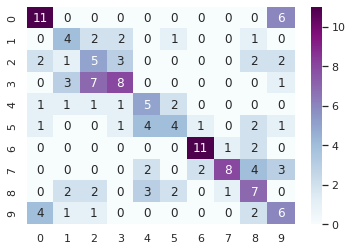

In [18]:
# Test
y_pred = clf.predict(X_test)

# Classificaiton report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
sn.set(font_scale=1.) # for label size
sn.heatmap(cm, annot=True, cmap="BuPu") # font size
plt.show()

## Model2: with zcr

In [19]:
# Data loading
X_train_zcr, X_test_zcr, y_train_zcr, y_test_zcr = load_data(feature_extractor=combo_v2, 
                                                             normalize=True)

In [20]:
# Number of training examples
print("Number of training examples:", len(X_train_zcr))
print("Number of test examples:", len(X_test_zcr))

Number of training examples: 1350
Number of test examples: 150


In [21]:
# Dimensionality of the training features
print("Number of training features: ", X_train_zcr[0].shape[0])

Number of training features:  5


### Model training 

In [22]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf_zcr = clf.fit(X_train_zcr, y_train_zcr)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 2.426s


In [23]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf_zcr.best_estimator_.C))
print(' gamma: '+str(clf_zcr.best_estimator_.gamma))

Best parameters combination:
 C: 1000.0
 gamma: 0.1


### Model testing

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        17
           1       0.50      0.80      0.62        10
           2       0.60      0.60      0.60        15
           3       0.67      0.53      0.59        19
           4       0.46      0.55      0.50        11
           5       0.44      0.57      0.50        14
           6       0.93      0.93      0.93        14
           7       0.67      0.32      0.43        19
           8       0.61      0.65      0.63        17
           9       0.69      0.64      0.67        14

    accuracy                           0.63       150
   macro avg       0.63      0.64      0.62       150
weighted avg       0.64      0.63      0.62       150

Confusion matrix:
[[14  0  1  0  0  0  0  0  0  2]
 [ 0  8  0  1  0  1  0  0  0  0]
 [ 1  0  9  1  0  1  1  0  2  0]
 [ 0  2  3 10  1  3  0  0  0  0]
 [ 1  2  1  1  6  0  0  0  0  0]
 [ 0  1  0  0  1  8  0  3  0  1]
 [

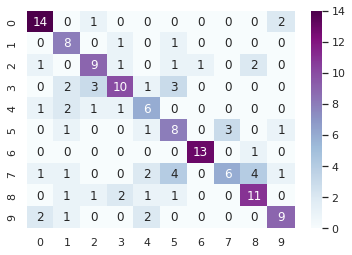

In [26]:
# Test
y_pred_zcr = clf_zcr.predict(X_test_zcr)

# Classificaiton report
print('Classification report:')
print(classification_report(y_test_zcr, y_pred_zcr))

# Confusion matrix
print('Confusion matrix:')
cm_zcr = confusion_matrix(y_test_zcr, y_pred_zcr)
print(cm_zcr)
sn.set(font_scale=1.) # for label size
sn.heatmap(cm_zcr, annot=True, cmap="BuPu") # font size

plt.show()

## Model1 vs Model2 (zcr)
Si riporta di seguito una breve analisi conclusiva sul contronto tra i due modelli.

### Grafico di confronto tra le performance

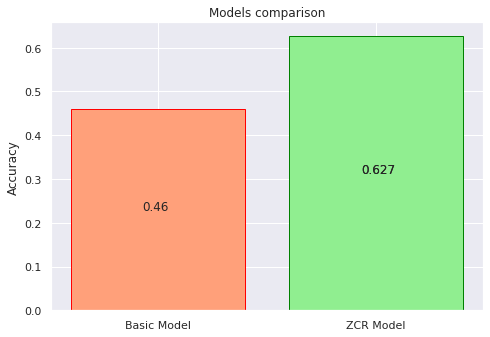

In [27]:
# calcolo il report di classificazione facendomi resitituire un dizionario
cl_report = classification_report(y_test, y_pred, output_dict=True)
cl_report_zcr = classification_report(y_test_zcr, y_pred_zcr, output_dict=True)
# estraggo l'accuracy totale dei due modelli
accuracy_mod1 = cl_report['accuracy']
accuracy_mod2 = cl_report_zcr['accuracy']


# plotto il confronto tra le due accuracy
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Basic Model', 'ZCR Model']
ax.bar(langs, [accuracy_mod1, accuracy_mod2], 
       color=["lightsalmon", "lightgreen"],  edgecolor=['red', 'green'])
ax.set_title('Models comparison')
ax.set_ylabel('Accuracy')

# print value in bar
for pos, val in zip([0,1], [accuracy_mod1, accuracy_mod2]):
  plt.text(pos-.07, val/2, round(val,3))

# adding value of second bar
plt.text(1-.07, accuracy_mod2/2, round(accuracy_mod2,3))

plt.show()

Visualizzo graficamente la differenza nelle performance ottenuta sui singoli numeri, il testo sulle barre riporta la differenza puntuale tra gli f-score dei due modelli.

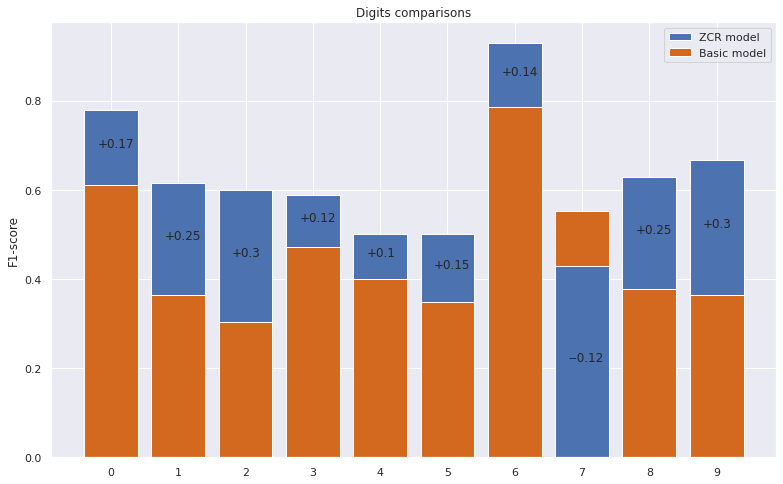

In [28]:
# extracting f1-score for each digit
labels = range(0, 10)
basic_digit = []
zcr_digit = []
for digit in labels:
  basic_digit.append(round(cl_report[str(digit)]['f1-score'], 3))
  zcr_digit.append(round(cl_report_zcr[str(digit)]['f1-score'], 3))

# extracting digit 7 -> value zcr > value basic
zcr_seven = zcr_digit.pop(7)
zcr_digit.insert(7,0)
basic_seven = basic_digit.pop(7)
basic_digit.insert(7,0)

# plot figure
width = 0.8     # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(figsize=(13,8))

# add bars
ax.bar(labels, zcr_digit, width, bottom = 0, label='ZCR model')
ax.bar(labels, basic_digit, width, bottom = 0, 
       color="chocolate", label='Basic model')
# plot digit 7's bar
ax.bar(labels[7], basic_seven, width, color="chocolate")
ax.bar(labels[7], zcr_seven, width, color="b")

# resetting value for digit 7
zcr_digit[7] = zcr_seven
basic_digit[7]= basic_seven

# print value in bar
for pos, z_val, b_val in zip(labels, zcr_digit, basic_digit):
  # get printed text with sign, setting also text position on y axis
  print_text = round(z_val-b_val,2)
  if(print_text > 0):
    y_pos = z_val-abs((z_val-b_val)/2)
    print_text = "+" + str(print_text)
  else:
    y_pos = z_val / 2
    print_text = "-" + str(print_text)
  plt.text(pos-.2, y_pos , print_text)


# setting labels
ax.set_ylabel('F1-score')
ax.set_title('Digits comparisons')
ax.legend()

plt.xticks(range(10))
plt.show()

Da questo grafico risulta evidente che il modello che utilizza anche la feature zrc, riportato con le barre blu, riesca a migliorare la predizione in quasi tutte le casistiche.

### Conclusioni

<div style="text-align: justify">
Dalle analisi risulta evidente una <b>differenza nell'accuracy</b> tra i due modelli come si può notare anche dal grafico di confronto riportato, con un incremento di circa $0.2$ che corrisponde ad un aumento del $45\%$ delle performance. Questo è visibile anche dalle performance ottenute sulle singole cifre, il secondo modello ottiene infatti valori complessivamente più alti per tutte le cifre fatta esclusione per il numero $7$ che viene spesso predetto come $5$, $6$ o $8$ come si può notare dalla confusion matrix del secondo modello.  <br> 
Anche i <b>parametri ottimali</b> per la SVM risultano <b>leggermente diversi</b>, nel primo caso (senza zcr) sono infatti risultati essere $C = 1000$ e $\gamma = 0.5$, mentre nel modello con zcr cambia il valore ottimale del secondo parametro con $\gamma = 0.1$ mentre $C$ è rimasto invariato. <br>
Inoltre anche il <b>tempo di training</b> risulta essere minore con l'aggiunta della feature zcr.<br>
Queste considerazioni portano alla conclusione che la feature zcr sia molto utile nella classificazione dei segnali monodimensionali e che effettivamente sia un buon improvement per il nostro classificatore, questo nonostante lo zcr sia soltanto uno scalare e quindi abbastanza basilare come feature.
<div/>

## Model3: MFCC (Mel-Frequency Cepstral Coefficients)

In [29]:
rate, audio = wav.read('./recordings/0_jackson_0.wav')
ipd.Audio(audio, rate=rate)

In [30]:
mfccs = librosa.feature.mfcc(audio*1.0, sr=rate)
mfccs.shape

(20, 11)

**Note:**

The first dimension size (20) depends on the choice of the frequencies/coefficients.

The first dimension size (11) depends on the duration of the audio track.

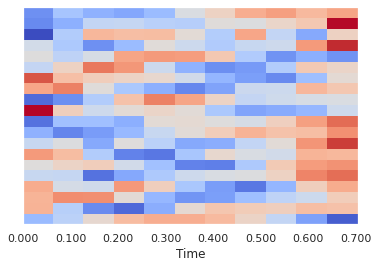

In [31]:
mfccs = scale(mfccs, axis=1)
lid.specshow(mfccs, sr=rate, x_axis='time')

### MFCC features for classification
MFCC estrae delle features che sono largamente utilizzate per la classificazione dei segnali audio. Mel campiona più frequentemente nelle frequenze in cui l'orecchio umano è molto più sensibile, solitamente questo ottiene buone performance perchè la pronuncia di molte parole/numeri è facilmente distinguibile all'orecchio umano perchè si è evoluta con noi.

In [32]:
def mfcc(input, rate=8000, min_len=40, sampling=1):
    # Sample values
    signal = input[::sampling]
    # Compute MFCC coefficients
    mfcc = librosa.feature.mfcc(signal*1.0, sr=int(rate/sampling))
    # Add additional necessary zeroes to reach the required length
    pad_width = min_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    # Flatten into monodimensional vector for the SVM
    mfcc = mfcc.flatten()
    return mfcc

### Model training

In [ ]:
# rieseguo la classificazione con crop_sdev
X_train_mel, X_test_mel, y_train_mel, y_test_mel = load_data(feature_extractor=mfcc, normalize=True)

In [35]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf_mel = clf.fit(X_train_mel, y_train_mel)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 34.843s


In [38]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf_mel.best_estimator_.C))
print(' gamma: '+str(clf_mel.best_estimator_.gamma))

Best parameters combination:
 C: 100.0
 gamma: 0.005


### Model testing

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      0.93      0.96        14
           6       0.82      1.00      0.90        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       1.00      0.93      0.96        14

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Confusion matrix:
[[17  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0 13  1  0  0  0]
 [

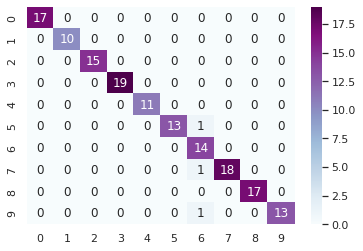

In [37]:
# Test
y_pred_mel = clf_mel.predict(X_test_mel)

# Classificaiton report
print('Classification report:')
print(classification_report(y_test_mel, y_pred_mel))

# Confusion matrix
print('Confusion matrix:')
cm_mel = confusion_matrix(y_test_mel, y_pred_mel)
print(cm_mel)
sn.set(font_scale=1.) # for label size
sn.heatmap(cm_mel, annot=True, cmap="BuPu") # font size

plt.show()

## Model3 vs Model2
Come prevedibile il modello 3 risulta essere molto meglio del modello con zcr nel predire la classe di appartenenza di un dato numero raggiungengo soglie molto alte per tutte le metriche. Questo era appunto prevedibile per via del fatto che le features di MEL sono state studiate apposta per questo tipo di task, come già detto.

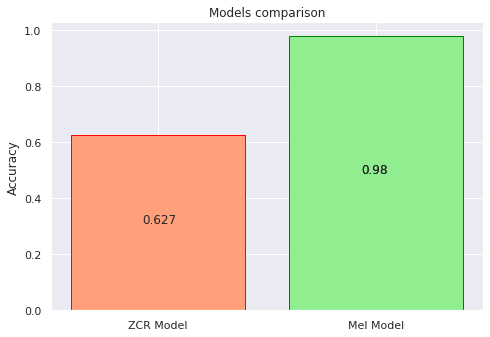

In [48]:
# calcolo il report di classificazione facendomi resitituire un dizionario
cl_report_mel = classification_report(y_test_mel, y_pred_mel, output_dict=True)

# estraggo l'accuracy totale dei due modelli
accuracy_mod1 = cl_report_zcr['accuracy']
accuracy_mod2 = cl_report_mel['accuracy']

# plotto il confronto tra le due accuracy
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['ZCR Model', 'Mel Model']
ax.bar(langs, [accuracy_mod1, accuracy_mod2], 
       color=["lightsalmon", "lightgreen"],  edgecolor=['red', 'green'])
ax.set_title('Models comparison')
ax.set_ylabel('Accuracy')

# print value in bar
for pos, val in zip([0,1], [accuracy_mod1, accuracy_mod2]):
  plt.text(pos-.07, val/2, round(val,3))

# adding value of second bar
plt.text(1-.07, accuracy_mod2/2, round(accuracy_mod2,3))

plt.show()

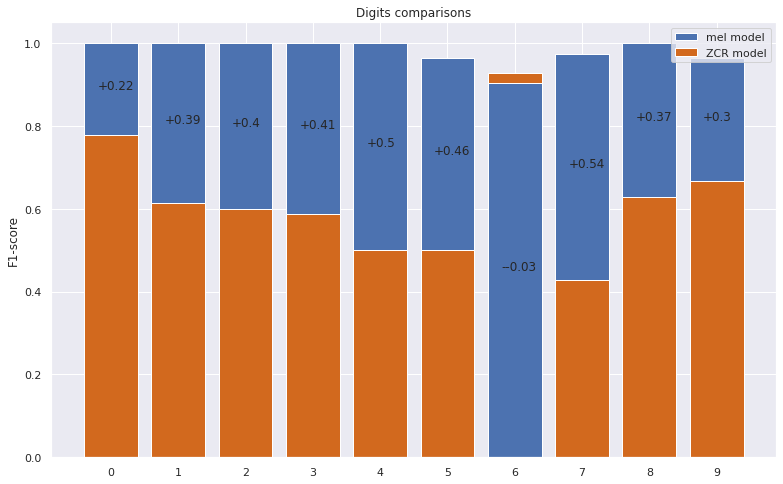

In [47]:


# extracting f1-score for each digit
labels = range(0, 10)
mel_digit = []
zcr_digit = []
for digit in labels:
  mel_digit.append(round(cl_report_mel[str(digit)]['f1-score'], 3))
  zcr_digit.append(round(cl_report_zcr[str(digit)]['f1-score'], 3))

# extracting digit 6 -> value zcr > value basic
mel_six = mel_digit.pop(6)
mel_digit.insert(6,0)
zcr_six = zcr_digit.pop(6)
zcr_digit.insert(6,0)

# plot figure
width = 0.8     # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(figsize=(13,8))

# add bars
ax.bar(labels, mel_digit, width, bottom = 0, label='mel model')
ax.bar(labels, zcr_digit, width, bottom = 0, 
       color="chocolate", label='ZCR model')
# plot digit 6's bar
ax.bar(labels[6], zcr_six, width, color="chocolate")
ax.bar(labels[6], mel_six, width, color="b")

# resetting value for digit 6
zcr_digit[6] = zcr_six
mel_digit[6]= mel_six


# print value in bar
for pos, z_val, b_val in zip(labels, mel_digit, zcr_digit):
  # get printed text with sign, setting also text position on y axis
  print_text = round(z_val-b_val,2)
  if(print_text > 0):
    y_pos = z_val-abs((z_val-b_val)/2)
    print_text = "+" + str(print_text)
  else:
    y_pos = z_val / 2
    print_text = "-" + str(print_text)
  plt.text(pos-.2, y_pos , print_text)


# setting labels
ax.set_ylabel('F1-score')
ax.set_title('Digits comparisons')
ax.legend()

plt.xticks(range(10))
plt.show()

<div style="text-align: justify">
Anche i grafici confermano il notevole miglioramento che si ottiene con le features di mel. Soltanto la cifra $6$ cala leggermente nella predizione, ma è un calo minimo se confrontato al beneficio che introducono queste features per tutte le altre cifre e quindi di conseguenza nel modello.<br>
Inoltre anche i parametri cambiano sensibilmente con queste nuove features anche se il tempo di training aumenta sensibilmente di oltre 10 volte.
<div/>

In [49]:
"""
%%shell
jupyter nbconvert --to html '/content/DSIM_Assignment1.ipynb'
"""

[NbConvertApp] Converting notebook /content/DSIM_Assignment1.ipynb to html
[NbConvertApp] Writing 527680 bytes to /content/DSIM_Assignment1.html
